# Readmission Risk for Heart Failure Patients

In [1]:
import mimicfouretl.bigquery_utils as bq
from mimicfouretl.data_insights import display_datasets
from mimicfouretl.query_builder import QueryBuilder
from mimicfouretl.feature_engineering import FeatureEngineering
from mimicfouretl.feature_engineering import left_merge_dataframes

from pyspark.sql.functions import col

from mimicfouretl.ml_utils import MLUtils

## Build BigQuery Spark session

In [2]:
bq.set_credentials_file('../bq_credentials/client_secret.json')
# bq.set_project_id('mimic-iv-418015')
bq.set_project_id('micro-vine-412020')

In [3]:
client = bq.get_client(use_service_account_auth=True)

In [4]:
tables = bq.list_tables('mimiciv_hosp', client)
tables

['mimiciv_hosp.admissions',
 'mimiciv_hosp.d_hcpcs',
 'mimiciv_hosp.d_icd_diagnoses',
 'mimiciv_hosp.d_icd_procedures',
 'mimiciv_hosp.d_labitems',
 'mimiciv_hosp.diagnoses_icd',
 'mimiciv_hosp.drgcodes',
 'mimiciv_hosp.emar',
 'mimiciv_hosp.emar_detail',
 'mimiciv_hosp.hcpcsevents',
 'mimiciv_hosp.labevents',
 'mimiciv_hosp.microbiologyevents',
 'mimiciv_hosp.omr',
 'mimiciv_hosp.patients',
 'mimiciv_hosp.pharmacy',
 'mimiciv_hosp.poe',
 'mimiciv_hosp.poe_detail',
 'mimiciv_hosp.prescriptions',
 'mimiciv_hosp.procedures_icd',
 'mimiciv_hosp.provider',
 'mimiciv_hosp.services',
 'mimiciv_hosp.transfers']

In [5]:
display_datasets()

Dropdown(description='Dataset:', options=('hosp.pharmacy', 'hosp.provider', 'hosp.poe_detail', 'hosp.admission…

Output()

In [6]:
spark = bq.get_spark_session(use_service_account_auth=True)

24/03/30 16:47:24 WARN Utils: Your hostname, Dunyas-Laptop.local resolves to a loopback address: 127.0.0.1; using 10.0.0.117 instead (on interface en0)
24/03/30 16:47:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/dunyaoguz/.ivy2/cache
The jars for the packages stored in: /Users/dunyaoguz/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-86af966f-4df1-4066-9a6c-e92fc77819e5;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/dunyaoguz/anaconda3/envs/mimic-iv-etl/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.37.0 in central
	[0.37.0] com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;latest.version
:: resolution report :: resolve 1337ms :: artifacts dl 2ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.37.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   1   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-86af966f-4df1-4066-9a6c-e92fc77819e5
	confs: [default]
	0 artifacts copied, 1 already retrieved (0kB/3ms)
24/03/30 16:47:26 WARN NativeCodeLoader: Unable to load native-hadoo

## Get relevant ICD codes and Lab Item IDs

### Get ICD codes for heart failure diagnoses

In [7]:
qb_heart_failure_codes = QueryBuilder(dataset='hosp.d_icd_diagnoses', 
                                      columns=['icd_code', 'icd_version', 'long_title'],
                                      filters="LOWER(long_title) LIKE '%heart failure%'")
heart_failure_codes_query = qb_heart_failure_codes.generate_query()
print(heart_failure_codes_query)

SELECT long_title, icd_code, icd_version
FROM `mimiciv_hosp.d_icd_diagnoses`
WHERE LOWER(long_title) LIKE '%heart failure%'


In [8]:
heart_failure_icd_items = bq.run_query(spark, heart_failure_codes_query)

In [9]:
heart_failure_icd_items.toPandas()

,long_title,icd_code,icd_version
0,"Hypertensive heart and chronic kidney disease, malignant, without heart failure and with chronic kidney disease stage V or end stage renal disease",40402,9
1,"Congestive heart failure, unspecified",4280,9
2,"Hypertensive heart and chronic kidney disease, malignant, without heart failure and with chronic kidney disease stage I through stage IV, or unspecified",40400,9
3,Chronic combined systolic and diastolic heart failure,42842,9
4,"Heart failure, unspecified",4289,9
...,...,...,...
68,Chronic right heart failure,I50812,10
69,Diastolic (congestive) heart failure,I503,10
70,"Heart failure, unspecified",I509,10
71,Chronic systolic (congestive) heart failure,I5022,10


In [10]:
heart_failure_icd_codes_list = [row['icd_code'] for row in heart_failure_icd_items.select('icd_code').distinct().collect()]

In [11]:
heart_failure_icd_codes_str = "'" + "', '".join(heart_failure_icd_codes_list) + "'"

### Get itemids for BNP labs

In [12]:
qb_bnp_labs = QueryBuilder(dataset='hosp.d_labitems', 
                           columns=['itemid', 'label', 'fluid', 'category'],
                           filters=["LOWER(label) LIKE '%bnp%'", "fluid = 'Blood'"])
bnp_labs_query = qb_bnp_labs.generate_query()
print(bnp_labs_query)

SELECT category, label, fluid, itemid
FROM `mimiciv_hosp.d_labitems`
WHERE LOWER(label) LIKE '%bnp%' AND fluid = 'Blood'


In [13]:
bnp_lab_items = bq.run_query(spark, bnp_labs_query)

In [14]:
bnp_lab_items.toPandas()

,category,label,fluid,itemid
0,Chemistry,NTproBNP,Blood,50963


In [15]:
bnp_lab_itemids_list = [row['itemid'] for row in bnp_lab_items.select('itemid').distinct().collect()]

In [16]:
bnp_lab_itemids_str = ', '.join(str(itemid) for itemid in bnp_lab_itemids_list)

## Query MIMIC IV database for Heart Failure diagnoses and BNP labs

In [17]:
# Initialize QueryBuilders
qb_diagnoses = QueryBuilder(dataset='hosp.diagnoses_icd', 
                            columns=['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version'],
                            filters=f'icd_code IN ({heart_failure_icd_codes_str})')

qb_labevents = QueryBuilder(dataset='hosp.labevents', 
                            columns=['subject_id', 'hadm_id', 'itemid', 'valuenum', 'ref_range_lower', 'ref_range_upper'],
                            filters=f'itemid IN ({bnp_lab_itemids_str})')

# Join datasets
qb_diagnoses.join_with(qb_labevents, join_type='inner', columns=['subject_id', 'hadm_id'])

# Generate query for joined data
qualifying_hosp_admissions_query = qb_diagnoses.generate_query(limit=100000)
# This query can now be used to extract the relevant joined data
print(qualifying_hosp_admissions_query)

SELECT ref_range_upper, `mimiciv_hosp.diagnoses_icd`.subject_id, icd_version, icd_code, `mimiciv_hosp.diagnoses_icd`.hadm_id, seq_num, itemid, valuenum, ref_range_lower
FROM `mimiciv_hosp.diagnoses_icd`
INNER JOIN `mimiciv_hosp.labevents` ON `mimiciv_hosp.diagnoses_icd`.subject_id = `mimiciv_hosp.labevents`.subject_id AND `mimiciv_hosp.diagnoses_icd`.hadm_id = `mimiciv_hosp.labevents`.hadm_id
WHERE icd_code IN ('I119', 'I5021', 'I5033', 'I509', 'I50814', '42842', '40413', '42830', 'I130', '40403', 'I50', 'I9713', '4289', '40412', 'I5032', '4280', '40291', 'I5042', 'I50811', '42833', 'I50812', 'I1311', 'I5041', 'I5043', '40211', '40411', 'I503', '40492', 'I5083', 'I110', '42821', '40401', '40410', 'I131', 'I5089', '40493', '42840', 'I0981', 'I5022', '40402', 'I97130', 'I50810', 'I97131', 'I508', 'I5081', 'I5084', '40400', 'I5020', '42832', 'I5040', 'I5023', '42841', '40491', '42843', '40200', '42822', '40490', '39891', 'I504', 'I502', '40210', '40290', 'I5031', 'I5030', '4281', 'I50813'

In [18]:
qualifying_hosp_admissions_df = bq.run_query(spark, qualifying_hosp_admissions_query)

## Create binary feature checking if BNP value is outside of reference range

In [19]:
feature_engineer = FeatureEngineering(qualifying_hosp_admissions_df)

In [20]:
condition_str = "(valuenum < ref_range_lower) OR (valuenum > ref_range_upper)"
feature_engineer.create_conditional_feature(condition_str, "bnp_outside_ref_range")

In [21]:
qualifying_hosp_admissions_df = feature_engineer.get_processed_data()
qualifying_hosp_admissions_df.toPandas()

,ref_range_upper,subject_id,icd_version,icd_code,hadm_id,seq_num,itemid,valuenum,ref_range_lower,bnp_outside_ref_range
0,192.0,13455616,9,4280,23778490,6,50963,2639.0,0.0,1
1,192.0,13455616,10,I130,20663270,1,50963,1434.0,0.0,1
2,192.0,13455616,10,I130,23991472,1,50963,296.0,0.0,1
3,192.0,13455616,10,I5033,20663270,2,50963,224.0,0.0,1
4,192.0,13455616,9,42833,23778490,2,50963,2639.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
22461,852.0,11119871,10,I110,29511412,1,50963,4068.0,0.0,1
22462,852.0,11119871,10,I5023,29511412,15,50963,4068.0,0.0,1
22463,852.0,15592191,10,I5033,26453292,1,50963,782.0,0.0,0
22464,852.0,15592191,10,I5033,26453292,1,50963,973.0,0.0,1


## Get admissions data, filtered by Subject ID of Qualifying Patients

In [22]:
qualifying_hosp_admissions_subject_ids_list = [row['subject_id'] for row in qualifying_hosp_admissions_df.select('subject_id').distinct().collect()]

In [23]:
len(qualifying_hosp_admissions_subject_ids_list)

7536

In [24]:
qualifying_hosp_admissions_subject_ids_str = ', '.join(str(subject_id) for subject_id in qualifying_hosp_admissions_subject_ids_list)

In [25]:
# Initialize QueryBuilders
qb_admissions = QueryBuilder(dataset='hosp.admissions',
                             filters=f'subject_id IN ({qualifying_hosp_admissions_subject_ids_str})')

# Generate query for joined data
admissions_query = qb_admissions.generate_query(limit=100000)
# This query can now be used to extract the relevant joined data
#print(admissions_query)

In [26]:
admissions_df = bq.run_query(spark, admissions_query)

In [27]:
admissions_df.toPandas()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,17960448,27662227,2157-09-01T16:00,2157-09-07T17:10,None,URGENT,P491WZ,TRANSFER FROM HOSPITAL,HOME,Medicare,ENGLISH,MARRIED,WHITE,None,None,0
1,16651008,25588349,2144-06-13T19:50,2144-06-14T14:50,None,URGENT,P611A0,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicaid,ENGLISH,SINGLE,HISPANIC/LATINO - PUERTO RICAN,None,None,0
2,15014144,29599966,2189-04-06T04:37,2189-04-14T16:10,None,URGENT,P3529J,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE,2189-04-06T03:18,2189-04-06T06:06,0
3,17636096,27092866,2172-02-24T21:50,2172-03-30T16:20,None,URGENT,P29CGZ,TRANSFER FROM HOSPITAL,HOME,Medicaid,ENGLISH,SINGLE,WHITE,None,None,0
4,18034432,29407045,2159-08-10T20:14,2159-08-16T15:45,None,URGENT,P4507L,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,ENGLISH,WIDOWED,UNKNOWN,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45754,10850815,29529191,2143-08-02T08:00,2143-08-18T12:00,None,SURGICAL SAME DAY ADMISSION,P49EON,PHYSICIAN REFERRAL,REHAB,Medicare,ENGLISH,MARRIED,WHITE,None,None,0
45755,10264575,27726486,2183-01-10T07:15,2183-01-16T14:45,None,SURGICAL SAME DAY ADMISSION,P41R5N,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,None,None,0
45756,16233215,26325135,2125-04-12T01:36,2125-04-14T15:47,None,SURGICAL SAME DAY ADMISSION,P872K3,PHYSICIAN REFERRAL,HOME,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,None,None,0
45757,19978239,23112915,2122-05-29T07:30,2122-06-01T13:22,None,SURGICAL SAME DAY ADMISSION,P98DW0,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Other,ENGLISH,WIDOWED,WHITE,None,None,0


## Count Previous Admissions for Qualifying Patients

In [28]:
feature_engineer = FeatureEngineering(admissions_df)

In [29]:
feature_engineer.count_previous_events(
    partition_column='subject_id',
    order_column='admittime',
    event_column='hadm_id'
)

In [30]:
admissions_df = feature_engineer.get_processed_data()
admissions_df.toPandas()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,previous_hadm_id
0,10000980,29654838,2188-01-03T17:41,2188-01-05T17:30,None,EW EMER.,P20N5X,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2188-01-03T12:23,2188-01-03T18:42,0,0
1,10000980,26913865,2189-06-27T07:38,2189-07-03T03:00,None,EW EMER.,P30KEH,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2189-06-27T06:25,2189-06-27T08:42,0,1
2,10000980,24947999,2190-11-06T20:57,2190-11-08T15:58,None,EW EMER.,P434W4,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2190-11-06T15:30,2190-11-06T23:16,0,2
3,10000980,25242409,2191-04-03T18:48,2191-04-11T16:21,None,EW EMER.,P33K8A,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2191-04-03T12:36,2191-04-03T20:29,0,3
4,10000980,25911675,2191-05-23T15:33,2191-05-24T17:14,None,EW EMER.,P29CGZ,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2191-05-22T16:06,2191-05-23T17:56,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45754,19967684,25782860,2113-12-20T00:19,2113-12-23T17:36,None,OBSERVATION ADMIT,P536JC,EMERGENCY ROOM,HOME HEALTH CARE,Other,ENGLISH,WIDOWED,WHITE,2113-12-19T15:53,2113-12-20T01:47,0,0
45755,19973083,22962012,2123-09-21T13:46,2123-09-28T00:00,None,URGENT,P07HDB,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,BLACK/CARIBBEAN ISLAND,None,None,0,0
45756,19973083,21885760,2123-10-04T15:53,2123-10-09T20:09,None,OBSERVATION ADMIT,P47E1G,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,BLACK/CARIBBEAN ISLAND,None,None,0,1
45757,19973083,20741363,2123-10-12T04:00,2123-10-20T16:35,None,OBSERVATION ADMIT,P47E1G,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,BLACK/CARIBBEAN ISLAND,2123-10-12T01:51,2123-10-12T04:53,0,2


## Check for Readmission within 30, 90, and 180 days

In [31]:
feature_engineer.check_event_within_timeframe(
    partition_column='subject_id',
    event_column='admittime', 
    timeframe=30
)

In [32]:
feature_engineer.check_event_within_timeframe(
    partition_column='subject_id',
    event_column='admittime', 
    timeframe=90
)

In [33]:
feature_engineer.check_event_within_timeframe(
    partition_column='subject_id',
    event_column='admittime', 
    timeframe=180
)

In [34]:
admissions_df = feature_engineer.get_processed_data()
admissions_df.toPandas()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,race,edregtime,edouttime,hospital_expire_flag,previous_hadm_id,next_admittime_date,days_to_next_admittime,admittime_within_30_days,admittime_within_90_days,admittime_within_180_days
0,10000980,29654838,2188-01-03T17:41,2188-01-05T17:30,None,EW EMER.,P20N5X,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,BLACK/AFRICAN AMERICAN,2188-01-03T12:23,2188-01-03T18:42,0,0,2189-06-27T07:38,541.0,0,0,0
1,10000980,26913865,2189-06-27T07:38,2189-07-03T03:00,None,EW EMER.,P30KEH,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,BLACK/AFRICAN AMERICAN,2189-06-27T06:25,2189-06-27T08:42,0,1,2190-11-06T20:57,497.0,0,0,0
2,10000980,24947999,2190-11-06T20:57,2190-11-08T15:58,None,EW EMER.,P434W4,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,BLACK/AFRICAN AMERICAN,2190-11-06T15:30,2190-11-06T23:16,0,2,2191-04-03T18:48,148.0,0,0,1
3,10000980,25242409,2191-04-03T18:48,2191-04-11T16:21,None,EW EMER.,P33K8A,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,...,BLACK/AFRICAN AMERICAN,2191-04-03T12:36,2191-04-03T20:29,0,3,2191-05-23T15:33,50.0,0,1,1
4,10000980,25911675,2191-05-23T15:33,2191-05-24T17:14,None,EW EMER.,P29CGZ,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,BLACK/AFRICAN AMERICAN,2191-05-22T16:06,2191-05-23T17:56,0,4,2191-07-16T14:21,54.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45754,19967684,25782860,2113-12-20T00:19,2113-12-23T17:36,None,OBSERVATION ADMIT,P536JC,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,WHITE,2113-12-19T15:53,2113-12-20T01:47,0,0,None,NaN,0,0,0
45755,19973083,22962012,2123-09-21T13:46,2123-09-28T00:00,None,URGENT,P07HDB,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,...,BLACK/CARIBBEAN ISLAND,None,None,0,0,2123-10-04T15:53,13.0,1,1,1
45756,19973083,21885760,2123-10-04T15:53,2123-10-09T20:09,None,OBSERVATION ADMIT,P47E1G,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,...,BLACK/CARIBBEAN ISLAND,None,None,0,1,2123-10-12T04:00,8.0,1,1,1
45757,19973083,20741363,2123-10-12T04:00,2123-10-20T16:35,None,OBSERVATION ADMIT,P47E1G,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Other,...,BLACK/CARIBBEAN ISLAND,2123-10-12T01:51,2123-10-12T04:53,0,2,2123-10-26T02:05,14.0,1,1,1


## Merge Admissions data with Qualifying Admissions data

In [35]:
merged_df = left_merge_dataframes(qualifying_hosp_admissions_df, admissions_df, ['subject_id', 'hadm_id'])

In [36]:
merged_df.toPandas()

24/03/30 16:48:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,ref_range_upper,subject_id,icd_version,icd_code,hadm_id,seq_num,itemid,valuenum,ref_range_lower,bnp_outside_ref_range,...,race,edregtime,edouttime,hospital_expire_flag,previous_hadm_id,next_admittime_date,days_to_next_admittime,admittime_within_30_days,admittime_within_90_days,admittime_within_180_days
0,192.0,13455616,9,4280,23778490,6,50963,2639.0,0.0,1,...,BLACK/AFRICAN AMERICAN,2182-05-24T10:07,2182-05-24T20:11,0,0,2182-06-06T06:33,13.0,1,1,1
1,192.0,13455616,10,I130,20663270,1,50963,1434.0,0.0,1,...,BLACK/AFRICAN AMERICAN,None,None,0,3,2184-10-07T21:05,20.0,1,1,1
2,192.0,13455616,10,I130,23991472,1,50963,296.0,0.0,1,...,BLACK/AFRICAN AMERICAN,None,None,0,8,2186-01-17T00:00,180.0,0,0,1
3,192.0,13455616,10,I5033,20663270,2,50963,224.0,0.0,1,...,BLACK/AFRICAN AMERICAN,None,None,0,3,2184-10-07T21:05,20.0,1,1,1
4,192.0,13455616,9,42833,23778490,2,50963,2639.0,0.0,1,...,BLACK/AFRICAN AMERICAN,2182-05-24T10:07,2182-05-24T20:11,0,0,2182-06-06T06:33,13.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22461,852.0,11119871,10,I110,29511412,1,50963,4068.0,0.0,1,...,WHITE,None,None,0,0,None,NaN,0,0,0
22462,852.0,11119871,10,I5023,29511412,15,50963,4068.0,0.0,1,...,WHITE,None,None,0,0,None,NaN,0,0,0
22463,852.0,15592191,10,I5033,26453292,1,50963,782.0,0.0,0,...,WHITE - OTHER EUROPEAN,None,None,0,0,2189-06-27T10:49,375.0,0,0,0
22464,852.0,15592191,10,I5033,26453292,1,50963,973.0,0.0,1,...,WHITE - OTHER EUROPEAN,None,None,0,0,2189-06-27T10:49,375.0,0,0,0


## Get Patient Data for Qualifying Patients

In [37]:
# Initialize QueryBuilders
qb_patients = QueryBuilder(dataset='hosp.patients',
                           columns=['subject_id', 'gender', 'anchor_age'],
                           filters=f'subject_id IN ({qualifying_hosp_admissions_subject_ids_str})')

# Generate query for joined data
patients_query = qb_patients.generate_query(limit=100000)
# This query can now be used to extract the relevant joined data
# print(patients_query)

In [38]:
patients_df = bq.run_query(spark, patients_query)

In [39]:
patients_df.toPandas()

,subject_id,anchor_age,gender
0,14958899,18,F
1,17719678,19,F
2,12133624,19,F
3,10751849,23,F
4,17651038,23,F
...,...,...,...
7531,15358321,91,M
7532,16271251,91,M
7533,17881091,91,M
7534,18913442,91,M


### Merge Patients Data

In [40]:
merged_df = left_merge_dataframes(merged_df, patients_df, ['subject_id'])

## Create Demographic Features

In [41]:
feature_engineer = FeatureEngineering(merged_df)

In [42]:
condition_str = "LOWER(gender) LIKE '%m%'"
feature_engineer.create_conditional_feature(condition_str, "gender_male")

In [43]:
condition_str = "LOWER(race) LIKE '%white%'"
feature_engineer.create_conditional_feature(condition_str, "race_white")

In [44]:
condition_str = "LOWER(race) LIKE '%black%'"
feature_engineer.create_conditional_feature(condition_str, "race_black")

In [45]:
condition_str = "LOWER(race) LIKE '%hispanic%' OR LOWER(race) LIKE '%latino%'"
feature_engineer.create_conditional_feature(condition_str, "race_hispanic_latino")

In [46]:
condition_str = "LOWER(race) LIKE '%asian%'"
feature_engineer.create_conditional_feature(condition_str, "race_asian")

In [47]:
condition_str = "LOWER(insurance) LIKE '%medicare%'"
feature_engineer.create_conditional_feature(condition_str, "insurance_medicare")

In [48]:
condition_str = "LOWER(insurance) LIKE '%medicaid%'"
feature_engineer.create_conditional_feature(condition_str, "insurance_medicaid")

In [49]:
condition_str = "LOWER(marital_status) LIKE '%married%'"
feature_engineer.create_conditional_feature(condition_str, "marital_status_married")

In [50]:
condition_str = "LOWER(marital_status) LIKE '%single%'"
feature_engineer.create_conditional_feature(condition_str, "marital_status_single")

In [51]:
condition_str = "LOWER(marital_status) LIKE '%widowed%'"
feature_engineer.create_conditional_feature(condition_str, "marital_status_widowed")

In [52]:
condition_str = "LOWER(marital_status) LIKE '%divorced%'"
feature_engineer.create_conditional_feature(condition_str, "marital_status_divorced")

In [53]:
processed_df = feature_engineer.get_processed_data()

In [54]:
processed_df.toPandas()

,ref_range_upper,subject_id,icd_version,icd_code,hadm_id,seq_num,itemid,valuenum,ref_range_lower,bnp_outside_ref_range,...,race_white,race_black,race_hispanic_latino,race_asian,insurance_medicare,insurance_medicaid,marital_status_married,marital_status_single,marital_status_widowed,marital_status_divorced
0,192.0,13455616,9,4280,23778490,6,50963,2639.0,0.0,1,...,0,1,0,0,0,0,1,0,0,0
1,192.0,13455616,10,I130,20663270,1,50963,1434.0,0.0,1,...,0,1,0,0,0,0,1,0,0,0
2,192.0,13455616,10,I130,23991472,1,50963,296.0,0.0,1,...,0,1,0,0,0,0,1,0,0,0
3,192.0,13455616,10,I5033,20663270,2,50963,224.0,0.0,1,...,0,1,0,0,0,0,1,0,0,0
4,192.0,13455616,9,42833,23778490,2,50963,2639.0,0.0,1,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22461,852.0,11119871,10,I110,29511412,1,50963,4068.0,0.0,1,...,1,0,0,0,0,0,0,1,0,0
22462,852.0,11119871,10,I5023,29511412,15,50963,4068.0,0.0,1,...,1,0,0,0,0,0,0,1,0,0
22463,852.0,15592191,10,I5033,26453292,1,50963,782.0,0.0,0,...,1,0,0,0,1,0,1,0,0,0
22464,852.0,15592191,10,I5033,26453292,1,50963,973.0,0.0,1,...,1,0,0,0,1,0,1,0,0,0


## Clean up Final DataFrame

In [55]:
processed_df = processed_df.withColumnRenamed('previous_hadm_id', 'n_prev_hosp_admissions')

In [56]:
features = ['subject_id',
 'hadm_id',
 'seq_num',
 'admittime',
 'dischtime',
 'deathtime',
 'valuenum',
 'bnp_outside_ref_range',
 'n_prev_hosp_admissions',
 'anchor_age',
 'gender_male',
 'race_white',
 'race_black',
 'race_hispanic_latino',
 'race_asian',
 'insurance_medicare',
 'insurance_medicaid',
 'marital_status_married',
 'marital_status_single',
 'marital_status_widowed',
 'marital_status_divorced',
 'admittime_within_30_days',
 'admittime_within_90_days',
 'admittime_within_180_days']

In [57]:
final_df = processed_df.select([col(f) for f in features])
final_df.toPandas()

,subject_id,hadm_id,seq_num,admittime,dischtime,deathtime,valuenum,bnp_outside_ref_range,n_prev_hosp_admissions,anchor_age,...,race_asian,insurance_medicare,insurance_medicaid,marital_status_married,marital_status_single,marital_status_widowed,marital_status_divorced,admittime_within_30_days,admittime_within_90_days,admittime_within_180_days
0,13455616,23778490,6,2182-05-24T18:53,2182-06-02T18:00,None,2639.0,1,0,49,...,0,0,0,1,0,0,0,1,1,1
1,13455616,20663270,1,2184-09-17T00:00,2184-09-20T17:27,None,1434.0,1,3,49,...,0,0,0,1,0,0,0,1,1,1
2,13455616,23991472,1,2185-07-21T15:56,2185-07-28T15:43,None,296.0,1,8,49,...,0,0,0,1,0,0,0,0,0,1
3,13455616,20663270,2,2184-09-17T00:00,2184-09-20T17:27,None,224.0,1,3,49,...,0,0,0,1,0,0,0,1,1,1
4,13455616,23778490,2,2182-05-24T18:53,2182-06-02T18:00,None,2639.0,1,0,49,...,0,0,0,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22461,11119871,29511412,1,2155-03-25T15:58,2155-04-20T17:41,None,4068.0,1,0,76,...,0,0,0,0,1,0,0,0,0,0
22462,11119871,29511412,15,2155-03-25T15:58,2155-04-20T17:41,None,4068.0,1,0,76,...,0,0,0,0,1,0,0,0,0,0
22463,15592191,26453292,1,2188-06-17T14:02,2188-06-22T14:55,None,782.0,0,0,81,...,0,1,0,1,0,0,0,0,0,0
22464,15592191,26453292,1,2188-06-17T14:02,2188-06-22T14:55,None,973.0,1,0,81,...,0,1,0,1,0,0,0,0,0,0


Number of rows dropped: 1200
Minority Class Count: 6733, Majority Class Count: 8153
Minority/Majority Ratio: 0.8258
Undersampling Majority. New Minority/Majority Ratio: 0.9129


'Validation Metrics:'

{'accuracy': 0.6865203761755486,
 'precision': 0.6509775524981897,
 'recall': 0.634438955539873,
 'f1': 0.6426018584703359,
 'auc_roc': 0.6812916717913691}

'Test Metrics:'

{'accuracy': 0.6974921630094044,
 'precision': 0.6610049539985846,
 'recall': 0.6577464788732394,
 'f1': 0.6593716907871515,
 'auc_roc': 0.6935625049733428}

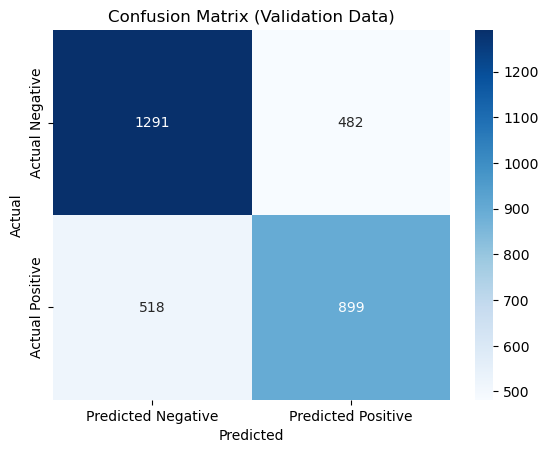

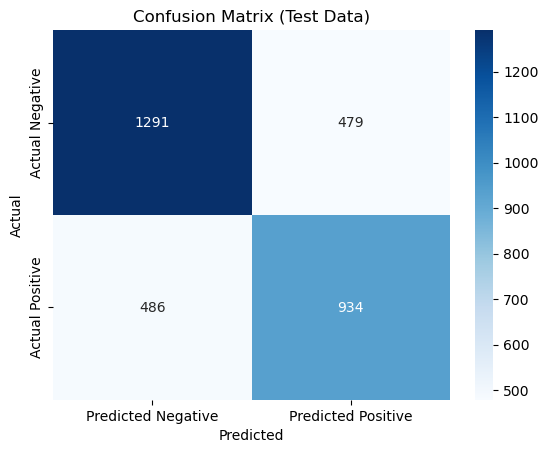

In [58]:
# Initialize MLUtils with the DataFrame
ml_utils = MLUtils(final_df)

# Set the target and feature columns
target_column = 'admittime_within_180_days' 
feature_columns = ['valuenum',
                   'bnp_outside_ref_range',
                   'n_prev_hosp_admissions',
                   'anchor_age',
                   'gender_male',
                   'race_white',
                   'race_black',
                   'race_hispanic_latino',
                   'race_asian',
                   'insurance_medicare',
                   'insurance_medicaid',
                   'marital_status_married',
                   'marital_status_single',
                   'marital_status_widowed',
                   'marital_status_divorced']

ml_utils.set_target(target_column)
ml_utils.set_features(feature_columns)

# Drop all rows where a feature or target value is NaN
ml_utils.clean_data(verbose=True)

# Split data into training, validation, and testing sets
ml_utils.split_data(ratio=(0.7, 0.15, 0.15))

# Train the model using XGBoost with SMOTE and undersampling
ml_utils.train_classification_model(smote=True, undersample_factor=0.5, verbose=True)

# Evaluate the model on validation and test datasets
validation_metrics = ml_utils.evaluate_classification_model(eval_type='val')
test_metrics = ml_utils.evaluate_classification_model(eval_type='test')

# Print evaluation metrics
display("Validation Metrics:", validation_metrics)
display("Test Metrics:", test_metrics)

ml_utils.display_confusion_matrix('val')
ml_utils.display_confusion_matrix('test')